In [0]:
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [0]:
raw = spark.table("silver.edgar_sarto_revenue.Idealista_CLEAN")

raw = raw.toPandas()

raw.head(2)

,Agency,District,Neighborhood,Street,€_Sqm,Monthly_Price,Security_Deposit,Additional_Costs,Elevator,Floor,Bathrooms,Bedrooms,Constructed_Area,City,Heating,Year_Built,Orientation,Terrace,Balcony,Parking,Temporart_Rentals,Furnished,State,Description
0,THE BEST RENT - APPARTAMENTI IN AFFITTO BREVE ...,ZONA GARIBALDI - PORTA VENEZIA,QUARTIERE CENTRALE,"\nVIA COPERNICO, 49\n",30.00,2100.0,NaN,NaN,1,3,1,2,70,MILAN,1,1950,sud,0,0,0,0,1,None,
1,QUIMMO PRESTIGE AGENCY,ZONA GARIBALDI - PORTA VENEZIA,QUARTIERE CENTRALE,"\nVIA GUSTAVO FARA, 13\n",25.93,3500.0,NaN,358.0,1,3,2,3,135,MILAN,1,1970,None,0,0,1,0,0,Buono stato,


In [0]:
raw['Elevator'] = raw['Elevator'].replace('', np.nan)
raw['Floor'] = raw['Floor'].replace('', np.nan)
raw['Bathrooms'] = raw['Bathrooms'].replace('', np.nan)
raw['Bedrooms'] = raw['Bedrooms'].replace('', np.nan)
raw['Constructed_Area'] = raw['Constructed_Area'].replace('', np.nan)
raw['Heating'] = raw['Heating'].replace('', np.nan)
raw['Additional_Costs'] = raw['Additional_Costs'].fillna(0)
raw['State'] = raw['State'].fillna('Buono stato')

raw['Elevator'] = raw['Elevator'].fillna(np.nan).astype(float)
raw['Floor'] = raw['Floor'].fillna(np.nan).astype(float)
raw['Bathrooms'] = raw['Bathrooms'].fillna(np.nan).astype(float)
raw['Bedrooms'] = raw['Bedrooms'].fillna(np.nan).astype(float)
raw['Constructed_Area'] = raw['Constructed_Area'].fillna(np.nan).astype(float)
raw['Heating'] = raw['Heating'].fillna(np.nan).astype(float)

In [0]:
raw['Neighborhood'] = raw['Neighborhood'].dropna()
raw['Orientation'] = raw['Orientation'].dropna()
raw['State'] = raw['State'].dropna()
raw['Elevator'] = raw['Elevator'].dropna()
raw['Floor'] = raw['Floor'].dropna()
raw['Bathrooms'] = raw['Bathrooms'].dropna()
raw['Bedrooms'] = raw['Bedrooms'].dropna()
raw['Constructed_Area'] = raw['Constructed_Area'].dropna()
raw['Heating'] = raw['Heating'].dropna()

#

## Remove Outliers

In [0]:
## TEST 2 - USING LOGARITHM OF THE DEPENDANT (LINEARIZES THE RELATIONSHIP IN FRONT OF EXPONENTIAL GROWTH)

#raw.loc[:,'Monthly_Price'] = np.log(raw['Monthly_Price'].replace(0, 1e-9))

In [0]:
raw['Price_0'] = np.nan
raw['Price_1'] = np.nan
raw['Price_2'] = np.nan
raw['Price_3'] = np.nan
raw['Price_4'] = np.nan
raw['Price_5'] = np.nan

raw = raw[raw['Bedrooms'] <= 5]
raw = raw[raw['Constructed_Area'] <= 200]
raw = raw[raw['Temporart_Rentals'] == 0]

def shif_beds (row):
    if row['Bedrooms'] == 0:
        row['Price_0'] = row['Monthly_Price']
    elif row['Bedrooms'] == 1:
        row['Price_1'] = row['Monthly_Price']
    elif row['Bedrooms'] == 2:
        row['Price_2'] = row['Monthly_Price']
    elif row['Bedrooms'] == 3:
        row['Price_3'] = row['Monthly_Price']
    elif row['Bedrooms'] == 4:
        row['Price_4'] = row['Monthly_Price']
    elif row['Bedrooms'] == 5:
        row['Price_5'] = row['Monthly_Price']
    return row


old_raw = raw.copy()

raw = raw.apply(shif_beds, axis=1)


#CHANGE THE PERCENTILS TO WHATEVER YOU THINK IT'S BETTER (IDEALLY DO 10-90)
lower_percentile = 15
upper_percentile = 85

price_columns = ['Price_0', 'Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']

for col in price_columns:
    lower_bound = np.percentile(raw[col].dropna(), lower_percentile)
    upper_bound = np.percentile(raw[col].dropna(), upper_percentile)
    raw = raw[(raw[col].isna()) | ((raw[col] >= lower_bound) & (raw[col] <= upper_bound))]

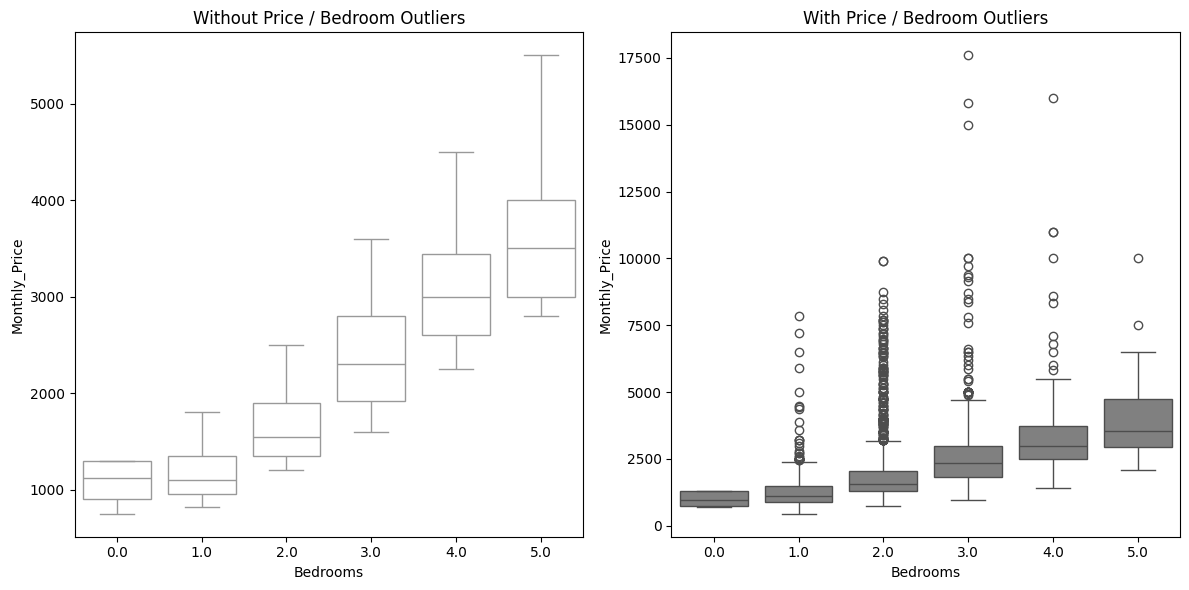

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=raw, x='Bedrooms', y='Monthly_Price', ax=axes[0], color='white')
axes[0].set_title('Without Price / Bedroom Outliers')

sns.boxplot(data=old_raw, x='Bedrooms', y='Monthly_Price', ax=axes[1], color='gray')
axes[1].set_title('With Price / Bedroom Outliers')

plt.tight_layout()
plt.show()

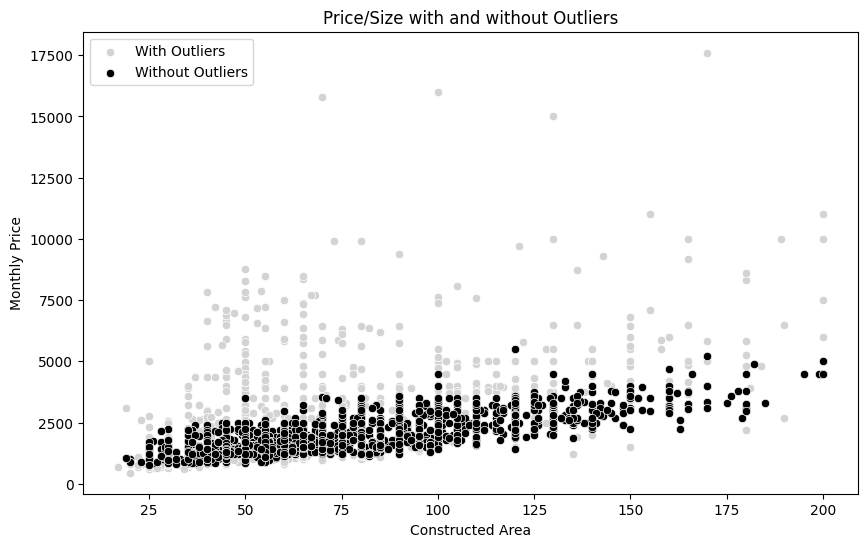

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.scatterplot(data=old_raw, x='Constructed_Area', y='Monthly_Price', color='lightgray', label='With Outliers')

sns.scatterplot(data=raw, x='Constructed_Area', y='Monthly_Price', color='black', label='Without Outliers')

plt.title('Price/Size with and without Outliers')
plt.xlabel('Constructed Area')
plt.ylabel('Monthly Price')
plt.legend()

plt.show()


In [0]:
raw = raw.drop(columns={'Security_Deposit', 'Year_Built', 'Description', 'Price_0', 'Price_1', 
                        'Price_2', 'Price_3', 'Price_4', 'Price_5', 'Agency', 'District', 'Orientation',
                        'Terrace'})

In [0]:
raw = raw.dropna()

In [0]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 3436
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Neighborhood       2116 non-null   object 
 1   Street             2116 non-null   object 
 2   €_Sqm              2116 non-null   float64
 3   Monthly_Price      2116 non-null   float64
 4   Additional_Costs   2116 non-null   float64
 5   Elevator           2116 non-null   float64
 6   Floor              2116 non-null   float64
 7   Bathrooms          2116 non-null   float64
 8   Bedrooms           2116 non-null   float64
 9   Constructed_Area   2116 non-null   float64
 10  City               2116 non-null   object 
 11  Heating            2116 non-null   float64
 12  Balcony            2116 non-null   int64  
 13  Parking            2116 non-null   int64  
 14  Temporart_Rentals  2116 non-null   int64  
 15  Furnished          2116 non-null   int64  
 16  State              2116 

## Price // Bedrooms // Bathrooms // Size 
######(Dist)

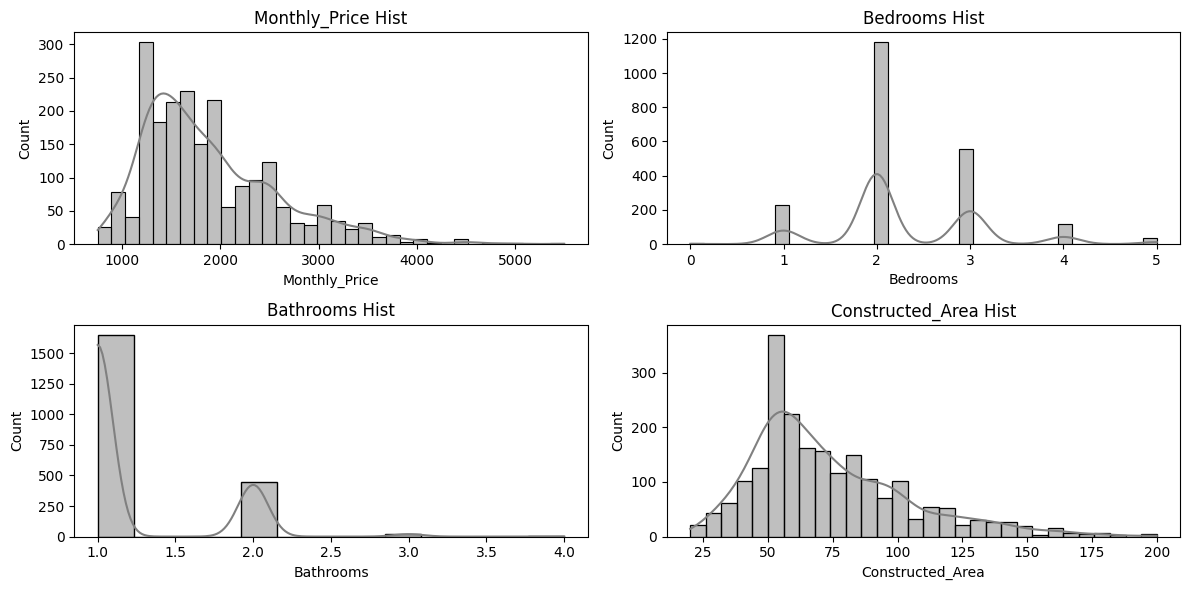

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(data=raw, x="Monthly_Price", ax=axes[0,0], kde=True, color='gray')
axes[0,0].set_title('Monthly_Price Hist')

sns.histplot(data=raw, x="Bedrooms", ax=axes[0,1], kde=True, color='gray')
axes[0,1].set_title('Bedrooms Hist')

sns.histplot(data=raw, x="Bathrooms", ax=axes[1,0], kde=True, color='gray')
axes[1,0].set_title('Bathrooms Hist')

sns.histplot(data=raw, x="Constructed_Area", ax=axes[1,1], kde=True, color='gray')
axes[1,1].set_title('Constructed_Area Hist')


plt.tight_layout()
plt.show()

## Independent Variables Definition

In [0]:
## CATEGORIAL TO DUMMIES
categoricas_1 = ['Neighborhood', 'State']

categoricas_1 = pd.get_dummies(raw[categoricas_1], drop_first=False).astype(int)


## DROP ONE OF THE DUMMY VARIABLES TO AVOID MULTICOLLINEARITY PROBLMES (Independent variables are correlated)
categoricas_1.drop(columns={'State_Buono stato', 'Neighborhood_QUARTIERE ACCURSIO'},
                   inplace=True)

categoricas_1

,Neighborhood_QUARTIERE ARIOSTO - MAGENTA,Neighborhood_QUARTIERE BANDE NERE - GAMBARA,Neighborhood_QUARTIERE BOCCONI,Neighborhood_QUARTIERE BOVISA,Neighborhood_QUARTIERE BRERA - MONTENAPOLEONE,Neighborhood_QUARTIERE BUENOS AIRES,Neighborhood_QUARTIERE CADORNA - CASTELLO,Neighborhood_QUARTIERE CARROBBIO - CINQUE VIE,Neighborhood_QUARTIERE CENISIO - SARPI,Neighborhood_QUARTIERE CENTRALE,Neighborhood_QUARTIERE CINQUE GIORNATE - CADORE,Neighborhood_QUARTIERE CITY LIFE,Neighborhood_QUARTIERE CORSO GENOVA,Neighborhood_QUARTIERE DERGANO,Neighborhood_QUARTIERE DUOMO - SAN BABILA,Neighborhood_QUARTIERE FIERA,Neighborhood_QUARTIERE GARIBALDI - CORSO COMO,Neighborhood_QUARTIERE GOTTARDO,Neighborhood_QUARTIERE GOVONE,Neighborhood_QUARTIERE INDIPENDENZA - REGINA GIOVANNA,Neighborhood_QUARTIERE ISOLA,Neighborhood_QUARTIERE LODI - BRENTA,Neighborhood_QUARTIERE LORENTEGGIO - GIAMBELLINO,Neighborhood_QUARTIERE MAGGIOLINA - VILLAGGIO DEI GIORNALISTI,Neighborhood_QUARTIERE MERCALLI - QUADRONNO,Neighborhood_QUARTIERE MISSORI - AUGUSTO,Neighborhood_QUARTIERE MORGAGNI - BACONE,Neighborhood_QUARTIERE MORGANTINI - SEGESTA,Neighborhood_QUARTIERE MOSCOVA,Neighborhood_QUARTIERE NAVIGLI - PORTA GENOVA,Neighborhood_QUARTIERE NAVIGLIO GRANDE - SAN CRISTOFORO,Neighborhood_QUARTIERE NOLO - BRIANZA - PASTEUR,Neighborhood_QUARTIERE PALESTRO - MONFORTE,Neighborhood_QUARTIERE PORTA NUOVA - TURATI,Neighborhood_QUARTIERE PORTA ROMANA,Neighborhood_QUARTIERE PORTA VENEZIA - REPUBBLICA,Neighborhood_QUARTIERE PORTA VITTORIA - CALVAIRATE,Neighborhood_QUARTIERE PORTELLO - TRE TORRI,Neighborhood_QUARTIERE PREALPI - TESTORI,Neighborhood_QUARTIERE QUADRILATERO DELLA MODA,Neighborhood_QUARTIERE ROMAGNA,Neighborhood_QUARTIERE SAN SIRO,Neighborhood_QUARTIERE SAN VITTORE - WASHINGTON,Neighborhood_QUARTIERE SEMPIONE,Neighborhood_QUARTIERE SODERINI,Neighborhood_QUARTIERE SOLARI - SAVONA,Neighborhood_QUARTIERE TIBALDI - PEZZOTTI,Neighborhood_QUARTIERE TRIBUNALE - GUASTALLA,Neighborhood_QUARTIERE ZONA SANT'AMBROGIO - UNIVERSITÀ CATTOLICA,State_Da ristrutturare,State_Nuova costruzione terminata
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3434,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3435,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
## NUMERICAL

numericas = ['Bathrooms','Bedrooms', 'Constructed_Area','Heating',
             'Parking', 'Furnished']

numericas = raw[numericas]

In [0]:
X = pd.concat([numericas, categoricas_1], axis=1)

X = X.dropna()

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 3436
Data columns (total 57 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Bathrooms                                                         2116 non-null   float64
 1   Bedrooms                                                          2116 non-null   float64
 2   Constructed_Area                                                  2116 non-null   float64
 3   Heating                                                           2116 non-null   float64
 4   Parking                                                           2116 non-null   int64  
 5   Furnished                                                         2116 non-null   int64  
 6   Neighborhood_QUARTIERE ARIOSTO - MAGENTA                          2116 non-null   int64  
 7   Neighborhood_QUARTIERE BANDE NERE

## Dependant Variable Definition

In [0]:
## TEST 1 - WITHOUT USING LOGARITHM OF THE DEPENDANT
y = raw['Monthly_Price']

In [0]:
y = y.dropna()

y.info()

<class 'pandas.core.series.Series'>
Int64Index: 2116 entries, 0 to 3436
Series name: Monthly_Price
Non-Null Count  Dtype  
--------------  -----  
2116 non-null   float64
dtypes: float64(1)
memory usage: 33.1 KB


#

# Regression

## Normal Linear Regression

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)

In [0]:
cross_val_score(model, X_train, y_train, cv=10)

array([0.6695385 , 0.77779906, 0.70050872, 0.69782777, 0.64970189,
       0.72442533, 0.71646621, 0.75882305, 0.53937421, 0.69974765])

In [0]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [0]:
Variable_Betas = model.coef_

feature_names = X.columns

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

linear_results = coefficients.append({'Feature': 'Intercept', 'Coefficient': model.intercept_}, ignore_index=True)

/home/spark-d61c513c-8388-4dd9-9b02-89/.ipykernel/300922/command-169800063051032-2532393055:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  linear_results = coefficients.append({'Feature': 'Intercept', 'Coefficient': model.intercept_}, ignore_index=True)


In [0]:
linear_score = model.score(X_test, y_test)
linear_mae = mean_squared_error(y_test, y_pred)

### Results Analysis

##### (R^2 // Adjusted R^2 // Std Errors // P-Values // T-test)

In [0]:
n, p = X_train.shape
y_pred_train = model.predict(X_train)
error_variance = np.var(y_train - y_pred_train, ddof=p + 1)

In [0]:
# INVERSE MATRIX TO GET COEFFICIENTS VARIANCE

XTX_inv = np.linalg.inv(X_train.T @ X_train + model.alpha * np.identity(p))
coef_variance = error_variance * XTX_inv.diagonal()

In [0]:
# T-test + P-value

t_values = model.coef_ / np.sqrt(coef_variance)
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n - p - 1)) for t in t_values]

In [0]:
model.score(X_test, y_test)

0.7327413318617897

In [0]:
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X.shape[1] - 1)
std_error = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"r2: {r2}")
print(f"adjusted_r2: {adjusted_r2}")
print(f"std_error: {std_error}")

r2: 0.7327413318617897
adjusted_r2: 0.6911190802664946
std_error: 363.75211334843937


In [0]:
## IF THE T-TEST ABSOLUT VALUE < 2 (it means that the variable is not statiscally significant) SO THEN DROP THAT VARIABLE AND RUN AGAIN THE REGRESSION

results = pd.DataFrame({
    'Variable': X.columns,
    'Beta': model.coef_,
    't_test': t_values,
    'p_value': p_values
})

print(results.to_string())

                                                            Variable        Beta     t_test       p_value
0                                                          Bathrooms  203.462354   7.569048  6.239453e-14
1                                                           Bedrooms  339.142489  16.654303  0.000000e+00
2                                                   Constructed_Area    7.572633  12.856667  0.000000e+00
3                                                            Heating  -81.720549  -2.939139  3.337444e-03
4                                                            Parking  193.204228   4.187616  2.969308e-05
5                                                          Furnished   76.605333   3.917909  9.300298e-05
6                           Neighborhood_QUARTIERE ARIOSTO - MAGENTA   72.567073   1.294205  1.957774e-01
7                        Neighborhood_QUARTIERE BANDE NERE - GAMBARA  -75.762516  -0.499525  6.174767e-01
8                                     Neighbor

<Figure size 640x480 with 0 Axes>

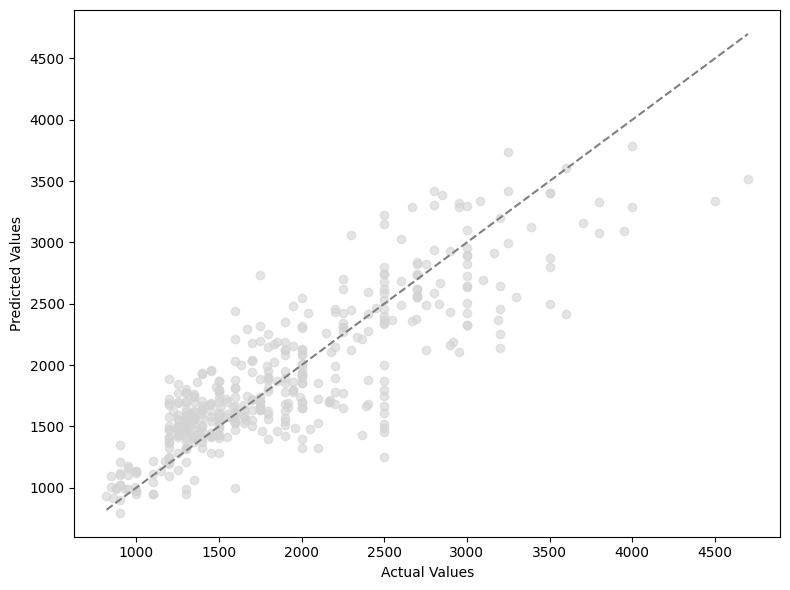

In [0]:
plt.clf()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='lightgray', alpha=0.6, label="Valores Predichos")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gray', linestyle='--')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.tight_layout()

plt.show()

##### (Test for Heteroskedasticity)

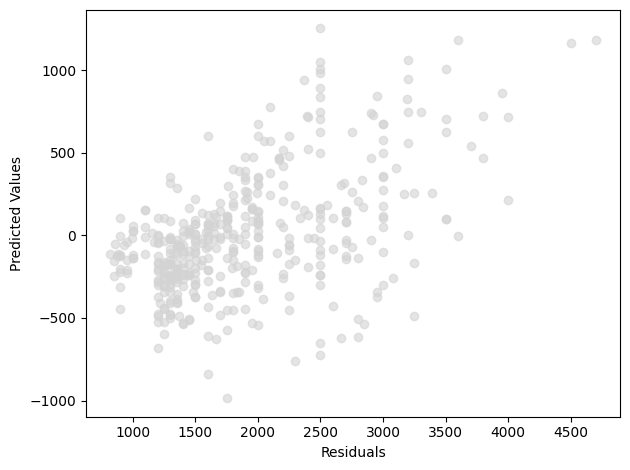

In [0]:
# TEST FOR HETEROSKEDASTICITY
    #https://corporatefinanceinstitute.com/resources/data-science/heteroskedasticity/#:~:text=Heteroskedasticity%20refers%20to%20situations%20where,known%20as%20the%20error%20term).

plt.clf()

residuals = y_test - y_pred
plt.scatter(y_test, residuals, color='lightgray', alpha=0.6, label="Valores Predichos")

plt.xlabel("Residuals")
plt.ylabel("Predicted Values")

plt.tight_layout()

plt.show()

In [0]:
## FOR THE WHITE TESTS, NULL HYPOTHESIS = NO HETEROSKEDASTICITY
    # if F-Test for p-value < 0.05 -> NULL hypothesis rejected -> NO heteroskedasticity
    # if F-Test for p-value > 0.05 -> NULL hypothesis NOT rejected -> We have heteroskedasticity

# if you have heteroskedasticity the least complicated thing to do is to perform a Robust Standard Errors
# https://stackoverflow.com/questions/58727200/robust-standard-errors-in-sklearn-linearregression


from statsmodels.stats.diagnostic import het_white

## Add a constant
Constant = sm.add_constant(X_test)

white_test = het_white(residuals,  Constant)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'Test Statistic': 261.5613687148313, 'Test Statistic p-value': 0.004013182915602495, 'F-Statistic': 1.7286148010189617, 'F-Test p-value': 3.7078560032576337e-05}


## OLS Robust Regress (Only in case of Heteroskedasticity)

In [0]:
## CAUTION WITH OVERFITTING THE MODEL - IF OVERFITTED AVOID THIS MODEL PLEASE!!!
numericas = ['Bathrooms','Bedrooms', 'Constructed_Area',
             'Parking', 'Furnished']

numericas = raw[numericas]

X = pd.concat([numericas, categoricas_1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ols_robust=sm.OLS(y_train, X_train,).fit(cov_type = "HC0")

ols_robust.summary()

/databricks/python/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 50
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Monthly_Price   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              63.97
Date:                Tue, 11 Mar 2025   Prob (F-statistic):                        0.00
Time:                        16:25:35   Log-Likelihood:                         -12352.
No. Observations:                1692   AIC:                                  2.481e+04
Df Residuals:                    1640   BIC:                                  2.509e+04
Df Model:                          52                                                  
Covariance Type:                  HC0                                                  
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Bathrooms                                                          206.7498     29.664      6.970      0.000     148.609     264.890
Bedrooms                                                           337.3431     22.816     14.785      0.000     292.624     382.062
Constructed_Area                                                     7.5604      0.668     11.324      0.000       6.252       8.869
Parking                                                            236.6040     57.974      4.081      0.000     122.977     350.231
Furnished                                                           78.2615     19.946      3.924      0.000      39.168     117.355
Neighborhood_QUARTIERE ARIOSTO - MAGENTA                           321.1592     60.619      5.298      0.000     202.349     439.969
Neighborhood_QUARTIERE BANDE NERE - GAMBARA                        149.5488    105.282      1.420      0.155     -56.800     355.897
Neighborhood_QUARTIERE BOCCONI                                     345.2913     86.326      4.000      0.000     176.095     514.488
Neighborhood_QUARTIERE BOVISA                                     -188.3860     65.473     -2.877      0.004    -316.710     -60.062
Neighborhood_QUARTIERE BRERA - MONTENAPOLEONE                      722.0398     80.069      9.018      0.000     565.107     878.972
Neighborhood_QUARTIERE BUENOS AIRES                                125.2743     78.639      1.593      0.111     -28.855     279.404
Neighborhood_QUARTIERE CADORNA - CASTELLO                          882.0235    243.693      3.619      0.000     404.394    1359.653
Neighborhood_QUARTIERE CARROBBIO - CINQUE VIE                      449.4510     66.355      6.773      0.000     319.397     579.505
Neighborhood_QUARTIERE CENISIO - SARPI                             242.6565     62.024      3.912      0.000     121.092     364.221
Neighborhood_QUARTIERE CENTRALE                                    -16.8109     75.313     -0.223      0.823    -164.421     130.799
Neighborhood_QUARTIERE CINQUE GIORNATE - CADORE                    174.0408     54.238      3.209      0.001      67.737     280.345
Neighborhood_QUARTIERE CITY LIFE                                   394.9821    245.637      1.608      0.108     -86.458     876.422
Neighborhood_QUARTIERE CORSO GENOVA                                217.5779     51.995      4.185      0.000     115.670     319.486
Neighborhood_QUARTIERE DERGANO                                     259.1770    116.438      2.226      0.026      30.963     487.391
Neighborhood_QUARTIERE DUOMO - SAN BABILA                 

In [0]:
preds_ols_robust = ols_robust.predict(X_test)
resid_ols_robust = y_test - preds_ols_robust

preds_linear = y_pred
resid_linear = residuals

<Figure size 640x480 with 0 Axes>

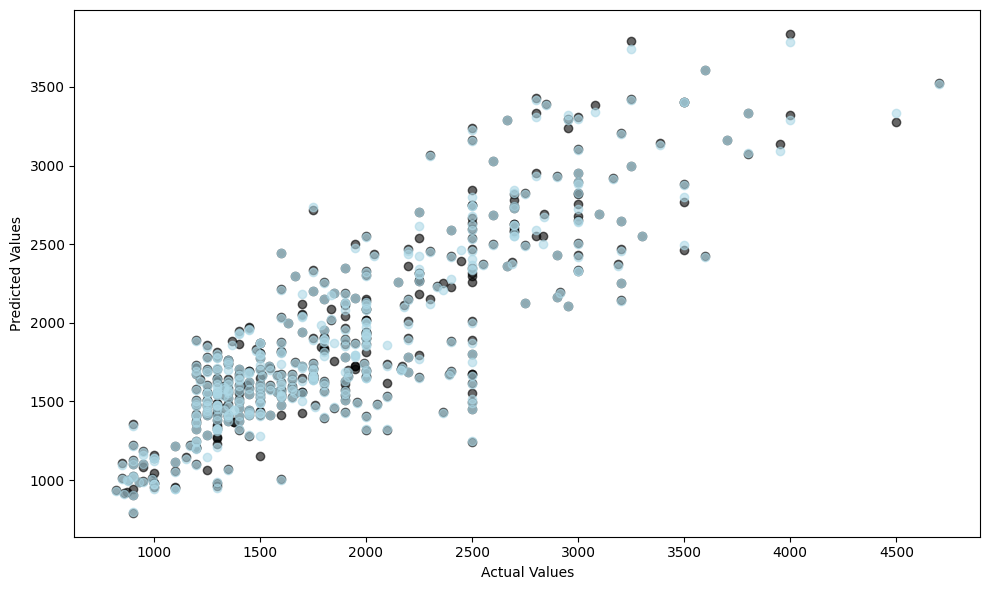

In [0]:
plt.clf()

plt.figure(figsize=(10,6))
plt.scatter(y_test, preds_ols_robust, color='black', alpha=0.6, label="Pred OLS")
plt.scatter(y_test, preds_linear, color='lightblue', alpha=0.6, label="Pred Linear")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

In [0]:
# TEST FOR HETEROSKEDASTICITY
    #https://corporatefinanceinstitute.com/resources/data-science/heteroskedasticity/#:~:text=Heteroskedasticity%20refers%20to%20situations%20where,known%20as%20the%20error%20term).


plt.figure(figsize=(10,6))

plt.scatter(resid_ols_robust, y_test, color='black', alpha=0.6, label="Pred OLS")
plt.scatter(resid_linear, y_test, color='lightblue', alpha=0.6, label="Pred Linear")

plt.xlabel("Residuals")
plt.ylabel("Predicted Values")

plt.tight_layout()

## SVR (Nonlinear params)

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
pipeline = make_pipeline(StandardScaler(), SVR())

In [0]:
param_grid_poly_test = {
    'svr__kernel': ['poly'],                                                 
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100],                                
    'svr__gamma': ['scale', 'auto'],                                         
    'svr__epsilon': [0.001, 0.01, 0.1, 1, 10],
    'svr__degree': [2,3,4,5]                                     
}

param_grid = {
    'svr__kernel': ['rbf', 'sigmoid'],                                                 
    'svr__C': [0.001, 0.01, 0.1, 1, 10, 100],                                
    'svr__gamma': ['scale', 'auto'],                                         
    'svr__epsilon': [0.001, 0.01, 0.1, 1, 10],                                 
}

In [0]:
#grid_search_poly_test = GridSearchCV(pipeline, param_grid_poly_test, cv=5, scoring='r2')
#grid_search_poly_test.fit(X_train, y_train)

In [0]:
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
#grid_search.fit(X_train, y_train)

In [0]:
#print(f'POLY: best r2', grid_search_poly_test.best_score_)
#print(f'OTHER: best r2', grid_search.best_score_)

#print(f'POLY: best params', grid_search_poly_test.best_params_)
#print(f'OTHER: best params', grid_search.best_params_)

In [0]:
regr_poly = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=3, gamma='scale', C=100, epsilon=0.001))
regr = make_pipeline(StandardScaler(), SVR(kernel='sigmoid', gamma='auto', C=100, epsilon=10))

In [0]:
cross_val_score(regr_poly, X_train, y_train, cv=10)

array([0.47202963, 0.5429247 , 0.38133535, 0.44147633, 0.46230385,
       0.45532537, 0.45594551, 0.44114461, 0.38887344, 0.49962899])

In [0]:
cross_val_score(regr, X_train, y_train, cv=10)

array([0.65497116, 0.76458977, 0.68352927, 0.69750749, 0.63854147,
       0.70730333, 0.6975317 , 0.73012836, 0.52086567, 0.67816846])

In [0]:
regr_poly.fit(X_train, y_train)
regr.fit(X_train, y_train)

SVR_Poly_Pred = regr_poly.predict(X_test)
SVR_Pred = regr.predict(X_test)

print(f'POLY: Model Score',regr_poly.score(X_train, y_train, sample_weight=None))
print(f'OTHER: Model Score',regr.score(X_train, y_train, sample_weight=None))

POLY: Model Score 0.5453075648989661
OTHER: Model Score 0.6928780298528147


In [0]:
svr_poly_score = regr_poly.score(X_train, y_train, sample_weight=None)
svr_sigmoid_score = regr.score(X_train, y_train, sample_weight=None)

svr_poly_mae = mean_squared_error(y_test, SVR_Poly_Pred)
svr_sigmoid_mae = mean_squared_error(y_test, SVR_Pred)

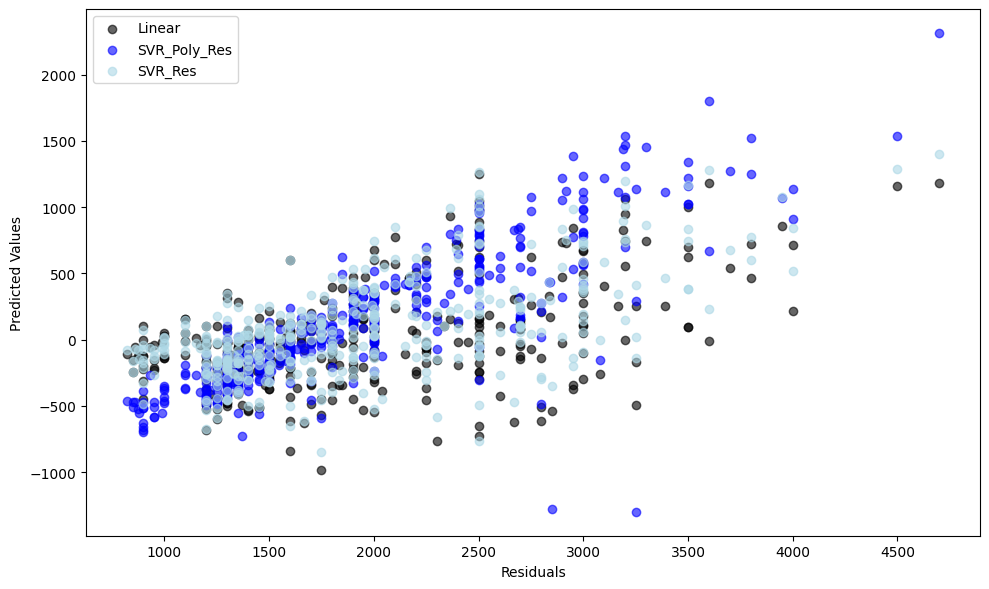

In [0]:
# Residuals
plt.clf()

SVR_Poly_Res = y_test - SVR_Poly_Pred
SVR_Res = y_test - SVR_Pred

plt.scatter(y_test, residuals, color='black', alpha=0.6, label="Linear")
plt.scatter(y_test, SVR_Poly_Res, color='blue', alpha=0.6, label="SVR_Poly_Res")
plt.scatter(y_test, SVR_Res, color='lightblue', alpha=0.6, label="SVR_Res")

plt.xlabel("Residuals")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

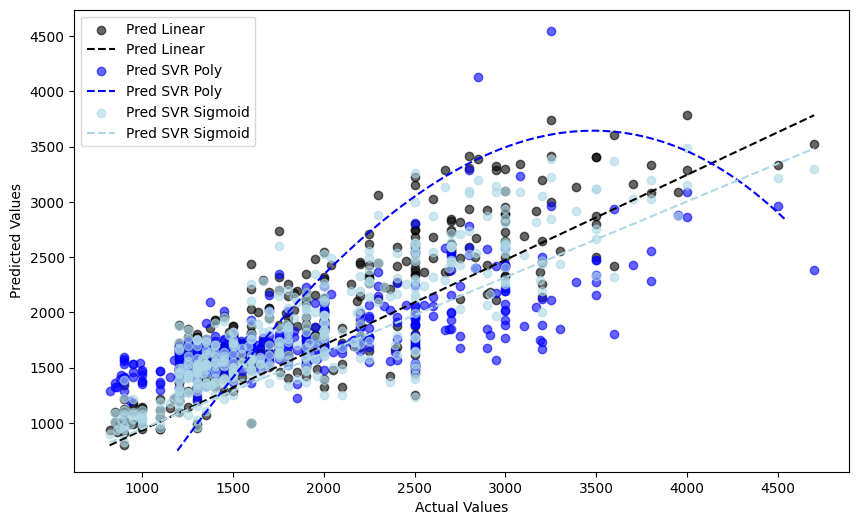

In [0]:
plt.clf()
plt.figure(figsize=(10,6))

plt.scatter(y_test, y_pred, color='black', alpha=0.6, label="Pred Linear")
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='black', linestyle='--', label='Pred Linear')


plt.scatter(y_test, SVR_Poly_Pred, color='blue', alpha=0.6, label="Pred SVR Poly")
### Poly line
coefficients = np.polyfit(SVR_Poly_Pred, y_test, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(SVR_Poly_Pred), max(SVR_Poly_Pred), 100)
y_values = polynomial(x_values)
plt.plot(x_values, y_values, color='blue', linestyle='--', label='Pred SVR Poly')



plt.scatter(y_test, SVR_Pred, color='lightblue', alpha=0.6, label="Pred SVR Sigmoid")
plt.plot([min(y_test), max(y_test)], [min(SVR_Pred), max(SVR_Pred)], color='lightblue', linestyle='--', label='Pred SVR Sigmoid')


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


## DecisionTreeRegressor

In [0]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor

In [0]:
tree_regress = DecisionTreeRegressor()

In [0]:
tree_params = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8],
    #'min_impurity_split': [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    #'max_samples': [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'splitter': ['best', 'random'],
    'random_state': [42],
    #'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
}

In [0]:
grid_search = GridSearchCV(tree_regress, tree_params, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

/databricks/python/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
44100 fits failed out of a total of 56700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18900 fits failed with the following error:
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/databricks/python_shell/lib/dbruntime/MLWorkloadsInstrumentation/_sklearn.py", line 29, in patch_function
    original_result = original(self, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/sklearn/base

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [None, 5, 10, 15, 20, 25, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'random_state': [42], 'splitter': ['best', 'random']},
             scoring='r2')

In [0]:
print(f'best r2', grid_search.best_score_)
print(f'best params', grid_search.best_params_)

best r2 0.6094079611946183
best params {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


In [0]:
tree_regress = DecisionTreeRegressor(criterion='squared_error',max_depth=30,max_features='sqrt',
                                     max_leaf_nodes=None,min_samples_split=15,
                                     random_state=42,splitter='best')

In [0]:
cross_val_score(tree_regress, X_train, y_train, cv=10)

array([0.597046  , 0.61567744, 0.59455629, 0.58397003, 0.55212884,
       0.68013261, 0.62852816, 0.62528581, 0.43052374, 0.63105183])

In [0]:
tree_regress.fit(X_train, y_train)

Tree_Pred = tree_regress.predict(X_test)

tree_regress.score(X_train, y_train)

0.7750489225730621

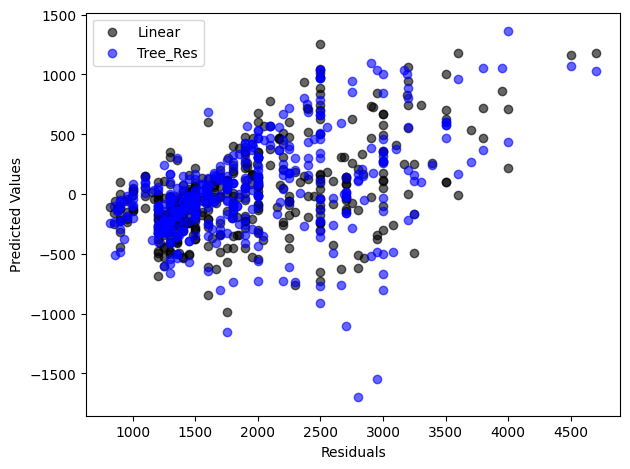

In [0]:
# Residuals
plt.clf()

Tree_Res = y_test - Tree_Pred

plt.scatter(y_test, residuals, color='black', alpha=0.6, label="Linear")
plt.scatter(y_test, Tree_Res, color='blue', alpha=0.6, label="Tree_Res")

plt.xlabel("Residuals")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

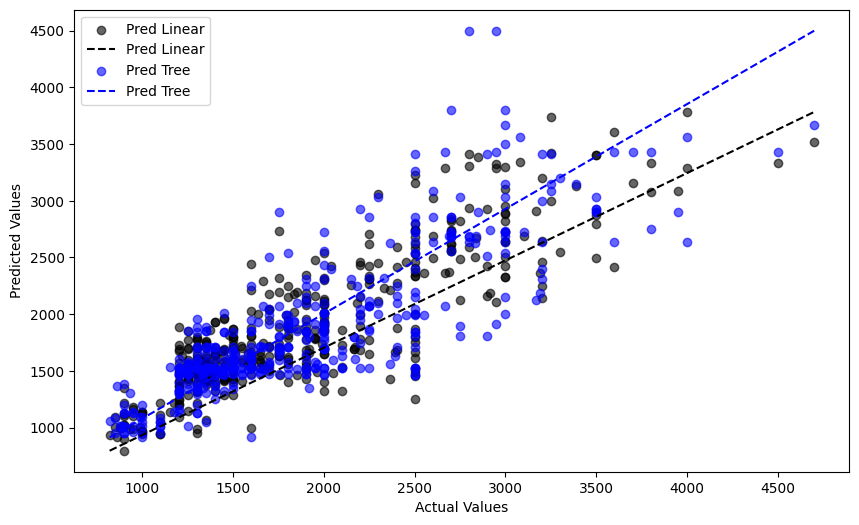

In [0]:
plt.clf()
plt.figure(figsize=(10,6))

plt.scatter(y_test, y_pred, color='black', alpha=0.6, label="Pred Linear")
plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], color='black', linestyle='--', label='Pred Linear')

plt.scatter(y_test, Tree_Pred, color='blue', alpha=0.6, label="Pred Tree")
plt.plot([min(y_test), max(y_test)], [min(Tree_Pred), max(Tree_Pred)], color='blue', linestyle='--', label='Pred Tree')


plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


In [0]:
tree_score = tree_regress.score(X_test, y_pred)
tree_mae = mean_squared_error(y_test, Tree_Pred)

In [0]:
n, p = X_train.shape
y_pred_train = tree_regress.predict(X_train)
error_variance = np.var(y_train - y_pred_train, ddof=p + 1)

In [0]:
XTX_inv = np.linalg.inv(X_train.T @ X_train + tree_regress.ccp_alpha * np.identity(p) + 1e-5 * np.identity(p))
coef_variance = error_variance * XTX_inv.diagonal()

In [0]:
from sklearn.tree import export_text

tree_coefs = export_text(tree_regress, feature_names=X.columns.tolist())
lineas_filtradas = [linea for linea in tree_coefs.splitlines() if "truncated branch" not in linea]
tree_coefs = "\n".join(lineas_filtradas)
print(tree_coefs)


|--- Neighborhood_QUARTIERE PORTA NUOVA - TURATI <= 0.50
|   |--- Bathrooms <= 1.50
|   |   |--- Bedrooms <= 2.50
|   |   |   |--- Neighborhood_QUARTIERE GOTTARDO <= 0.50
|   |   |   |   |--- Bedrooms <= 1.50
|   |   |   |   |   |--- Neighborhood_QUARTIERE PORTELLO - TRE TORRI <= 0.50
|   |   |   |   |   |   |--- Neighborhood_QUARTIERE BRERA - MONTENAPOLEONE <= 0.50
|   |   |   |   |   |   |   |--- Neighborhood_QUARTIERE CORSO GENOVA <= 0.50
|   |   |   |   |   |   |   |   |--- Constructed_Area <= 59.00
|   |   |   |   |   |   |   |   |   |--- Neighborhood_QUARTIERE FIERA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Constructed_Area <= 35.50
|   |   |   |   |   |   |   |   |   |   |--- Constructed_Area >  35.50
|   |   |   |   |   |   |   |   |   |--- Neighborhood_QUARTIERE FIERA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1090.00]
|   |   |   |   |   |   |   |   |--- Constructed_Area >  59.00
|   |   |   |   |   |   |   |   |   |--- value: [1530.71]
|   |   | 

In [0]:
imporance = tree_regress.feature_importances_
imporance = pd.DataFrame({'Característica': X.columns, 'Importancia': imporance})
imporance = imporance.sort_values('Importancia', ascending=False)
df_importancia

,Característica,Importancia
0,Bathrooms,0.464842
1,Bedrooms,0.255068
2,Constructed_Area,0.113354
38,Neighborhood_QUARTIERE PORTA NUOVA - TURATI,0.019209
33,Neighborhood_QUARTIERE MOSCOVA,0.010940
14,Neighborhood_QUARTIERE CENTRALE,0.009784
3,Parking,0.009686
30,Neighborhood_QUARTIERE MISSORI - AUGUSTO,0.007486
37,Neighborhood_QUARTIERE PALESTRO - MONFORTE,0.006915
9,Neighborhood_QUARTIERE BRERA - MONTENAPOLEONE,0.006245


In [0]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, Tree_Pred)
mse = mean_squared_error(y_test, Tree_Pred)
print("\nR²:", r2)
print("MSE:", mse)


R²: 0.6807412304419076
MSE: 158060.03948379582


## Model Comparasion

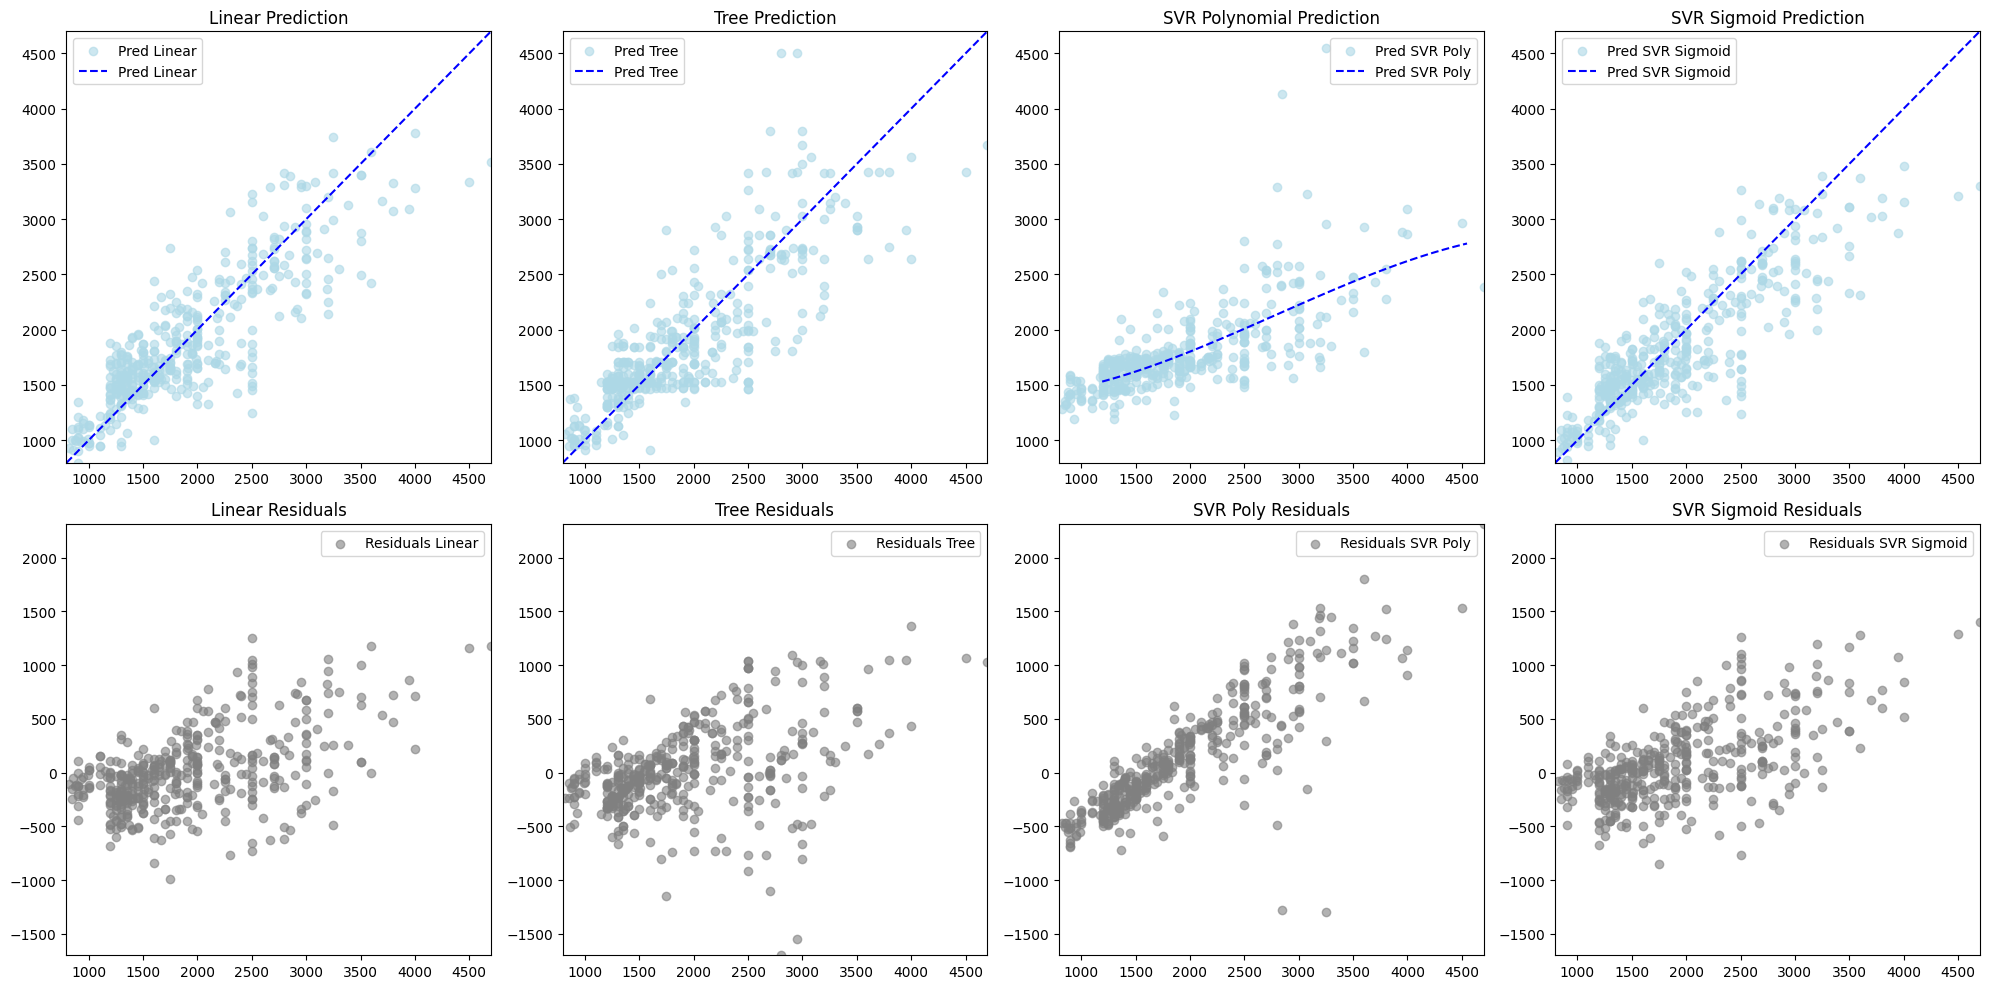

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, Tree_Pred, SVR_Poly_Pred, SVR_Pred, and their respective residuals are defined

x_min = min(np.min(y_test), np.min(y_pred), np.min(Tree_Pred), np.min(SVR_Poly_Pred), np.min(SVR_Pred))
x_max = max(np.max(y_test), np.max(y_pred), np.max(Tree_Pred), np.max(SVR_Poly_Pred), np.max(SVR_Pred))
y_min = x_min
y_max = x_max

x_min_res = min(np.min(y_test), np.min(residuals), np.min(Tree_Res), np.min(SVR_Poly_Res), np.min(SVR_Res))
x_max_res = max(np.max(residuals), np.max(Tree_Res), np.max(SVR_Poly_Res), np.max(SVR_Res))
y_min_res = x_min_res
y_max_res = x_max_res

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjusted figsize for better layout

# PREDICTIONS
# Scatter and line for Linear Prediction
axs[0, 0].scatter(y_test, y_pred, color='lightblue', alpha=0.6, label="Pred Linear")
axs[0, 0].plot([x_min, x_max], [x_min, x_max], color='blue', linestyle='--', label='Pred Linear')
axs[0, 0].set_xlim(x_min, x_max)
axs[0, 0].set_ylim(y_min, y_max)
axs[0, 0].set_title('Linear Prediction')
axs[0, 0].legend()

# Scatter and line for Tree Prediction
axs[0, 1].scatter(y_test, Tree_Pred, color='lightblue', alpha=0.6, label="Pred Tree")
axs[0, 1].plot([x_min, x_max], [x_min, x_max], color='blue', linestyle='--', label='Pred Tree')
axs[0, 1].set_xlim(x_min, x_max)
axs[0, 1].set_ylim(y_min, y_max)
axs[0, 1].set_title('Tree Prediction')
axs[0, 1].legend()

# Scatter and polynomial line for SVR Poly Prediction
axs[0, 2].scatter(y_test, SVR_Poly_Pred, color='lightblue', alpha=0.6, label="Pred SVR Poly")
coefficients = np.polyfit(y_test, SVR_Poly_Pred, 3)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(SVR_Poly_Pred), max(SVR_Poly_Pred), 100)
y_values = polynomial(x_values)
axs[0, 2].plot(x_values, y_values, color='blue', linestyle='--', label='Pred SVR Poly')
axs[0, 2].set_xlim(x_min, x_max)
axs[0, 2].set_ylim(y_min, y_max)
axs[0, 2].set_title('SVR Polynomial Prediction')
axs[0, 2].legend()

# Scatter and line for SVR Sigmoid Prediction
axs[0, 3].scatter(y_test, SVR_Pred, color='lightblue', alpha=0.6, label="Pred SVR Sigmoid")
axs[0, 3].plot([x_min, x_max], [x_min, x_max], color='blue', linestyle='--', label='Pred SVR Sigmoid')
axs[0, 3].set_xlim(x_min, x_max)
axs[0, 3].set_ylim(y_min, y_max)
axs[0, 3].set_title('SVR Sigmoid Prediction')
axs[0, 3].legend()

# RESIDUALS
# Scatter for Linear Residuals
std_residuals_linear = np.std(residuals)
axs[1, 0].scatter(y_test, residuals, color='gray', alpha=0.6, label="Residuals Linear")
axs[1, 0].set_xlim(x_min, x_max)
axs[1, 0].set_ylim(y_min_res, y_max_res)
axs[1, 0].set_title('Linear Residuals')
axs[1, 0].legend()

# Scatter for Tree Residuals
std_residuals_Tree = np.std(Tree_Res)
axs[1, 1].scatter(y_test, Tree_Res, color='gray', alpha=0.6, label="Residuals Tree")
axs[1, 1].set_xlim(x_min, x_max)
axs[1, 1].set_ylim(y_min_res, y_max_res)
axs[1, 1].set_title('Tree Residuals')
axs[1, 1 ].legend()

# Scatter for SVR Poly Residuals
std_residuals_Poly = np.std(SVR_Poly_Res)
axs[1, 2].scatter(y_test, SVR_Poly_Res, color='gray', alpha=0.6, label="Residuals SVR Poly")
axs[1, 2].set_xlim(x_min, x_max)
axs[1, 2].set_ylim(y_min_res, y_max_res)
axs[1, 2].set_title('SVR Poly Residuals')
axs[1, 2].legend()

# Scatter for SVR Sigmoid Residuals
std_residuals_Sigmoid = np.std(SVR_Res)
axs[1, 3].scatter(y_test, SVR_Res, color='gray', alpha=0.6, label="Residuals SVR Sigmoid")
axs[1, 3].set_xlim(x_min, x_max)
axs[1, 3].set_ylim(y_min_res, y_max_res)
axs[1, 3].set_title('SVR Sigmoid Residuals')
axs[1, 3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [0]:
metrics = {
    'Model': ['Linear Reress', 'Tree Regress', 'SVR Poly', 'SVR Sigmoid'],
    'R²': [linear_score, tree_score, svr_poly_score, svr_sigmoid_score],
    'MAE': [linear_mae, tree_mae, svr_poly_mae, svr_sigmoid_mae],
    'Std Res.': [std_residuals_linear, std_residuals_Tree, std_residuals_Poly, std_residuals_Sigmoid]
}

metrics_df = pd.DataFrame(metrics)

metrics_df

,Model,R²,MAE,Std Res.
0,Linear Reress,0.732741,132315.599965,363.686890
1,Tree Regress,0.829757,158060.039484,397.149366
2,SVR Poly,0.545308,272489.838376,508.393446
3,SVR Sigmoid,0.692878,141997.215302,369.508400


#